In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Directories
image_dir = "celebA/celeba/img_align_celeba"
os.makedirs("gan_outputs", exist_ok=True)

In [4]:
# Hyperparameters
z_dim = 100
lr = 2e-4
batch_size = 3000
n_epochs = 5
patience = 5

In [5]:
# Transformations
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
# Dataset and splits
full_dataset = datasets.ImageFolder(root=image_dir, transform=transform)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size  # ensure the sum matches exactly

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g * 4, features_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g * 2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, img_channels=3, features_d=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d, features_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d * 2, features_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d * 4, features_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.net(img).view(-1)

In [8]:
# Initialize models and optimizers
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

In [9]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

In [10]:
best_val_loss = float("inf")
epochs_no_improve = 0
train_losses = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
    G.train()
    D.train()
    running_loss_G = 0.0
    running_loss_D = 0.0

    print(f"Epoch [{epoch+1}/{n_epochs}]")
    for real_imgs, _ in tqdm(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = G(z).detach()
        D_real = D(real_imgs)
        D_fake = D(fake_imgs)
        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = G(z)
        D_fake = D(fake_imgs)
        loss_G = criterion(D_fake, real_labels)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        running_loss_D += loss_D.item()
        running_loss_G += loss_G.item()

    avg_train_loss_G = running_loss_G / len(train_loader)
    avg_train_loss_D = running_loss_D / len(train_loader)
    train_losses.append((avg_train_loss_D, avg_train_loss_G))

    # Validation step
    G.eval()
    D.eval()
    val_loss_D = 0.0
    val_loss_G = 0.0
    with torch.no_grad():
        for real_imgs, _ in val_loader:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            # Discriminator validation
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_imgs = G(z)
            D_real = D(real_imgs)
            D_fake = D(fake_imgs)
            loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

            # Generator validation
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_imgs = G(z)
            D_fake = D(fake_imgs)
            loss_G = criterion(D_fake, real_labels)

            val_loss_D += loss_D.item()
            val_loss_G += loss_G.item()

    avg_val_loss_D = val_loss_D / len(val_loader)
    avg_val_loss_G = val_loss_G / len(val_loader)
    val_losses.append((avg_val_loss_D, avg_val_loss_G))

    print(f"Train Loss D: {avg_train_loss_D:.4f}, G: {avg_train_loss_G:.4f} | Val Loss D: {avg_val_loss_D:.4f}, G: {avg_val_loss_G:.4f}")

    # Early stopping check
    if avg_val_loss_D + avg_val_loss_G < best_val_loss:
        best_val_loss = avg_val_loss_D + avg_val_loss_G
        epochs_no_improve = 0
        torch.save(G.state_dict(), "gan_outputs/best_generator.pth")
        torch.save(D.state_dict(), "gan_outputs/best_discriminator.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    # Save sample images
    with torch.no_grad():
        fake_imgs = G(fixed_noise).detach().cpu()
        grid = make_grid(fake_imgs, padding=2, normalize=True)
        save_image(grid, f"gan_outputs/epoch_{epoch+1}.png")

Epoch [1/5]


  0%|          | 0/55 [00:00<?, ?it/s]

  2%|▏         | 1/55 [00:08<08:00,  8.90s/it]

  4%|▎         | 2/55 [00:16<06:59,  7.92s/it]

  5%|▌         | 3/55 [00:22<06:08,  7.08s/it]

  7%|▋         | 4/55 [00:28<05:41,  6.70s/it]

  9%|▉         | 5/55 [00:34<05:33,  6.67s/it]

 11%|█         | 6/55 [00:40<05:14,  6.42s/it]

 13%|█▎        | 7/55 [00:46<04:49,  6.02s/it]

 15%|█▍        | 8/55 [00:51<04:37,  5.91s/it]

 16%|█▋        | 9/55 [00:58<04:49,  6.30s/it]

 18%|█▊        | 10/55 [01:05<04:41,  6.27s/it]

 20%|██        | 11/55 [01:11<04:38,  6.33s/it]

 22%|██▏       | 12/55 [01:17<04:24,  6.15s/it]

 24%|██▎       | 13/55 [01:23<04:22,  6.24s/it]

 25%|██▌       | 14/55 [01:29<04:13,  6.17s/it]

 27%|██▋       | 15/55 [01:35<03:59,  5.99s/it]

 29%|██▉       | 16/55 [01:42<04:10,  6.42s/it]

 31%|███       | 17/55 [01:50<04:17,  6.78s/it]

 33%|███▎      | 18/55 [01:57<04:09,  6.74s/it]

 35%|███▍      | 19/55 [02:03<04:03,  6.76s/it]

 36%|███▋      | 20/55 [02:09<03:42,  6.36s/it]

 38%|███▊      | 21/55 [02:15<03:33,  6.28s/it]

 40%|████      | 22/55 [02:21<03:27,  6.28s/it]

 42%|████▏     | 23/55 [02:27<03:21,  6.29s/it]

 44%|████▎     | 24/55 [02:34<03:13,  6.23s/it]

 45%|████▌     | 25/55 [02:40<03:08,  6.28s/it]

 47%|████▋     | 26/55 [02:45<02:51,  5.93s/it]

 49%|████▉     | 27/55 [02:51<02:47,  5.97s/it]

 51%|█████     | 28/55 [02:56<02:33,  5.70s/it]

 53%|█████▎    | 29/55 [03:02<02:31,  5.84s/it]

 55%|█████▍    | 30/55 [03:09<02:29,  5.98s/it]

 56%|█████▋    | 31/55 [03:14<02:22,  5.93s/it]

 58%|█████▊    | 32/55 [03:21<02:17,  5.97s/it]

 60%|██████    | 33/55 [03:27<02:12,  6.02s/it]

 62%|██████▏   | 34/55 [03:33<02:07,  6.05s/it]

 64%|██████▎   | 35/55 [03:38<01:57,  5.87s/it]

 65%|██████▌   | 36/55 [03:43<01:47,  5.66s/it]

 67%|██████▋   | 37/55 [03:47<01:32,  5.14s/it]

 69%|██████▉   | 38/55 [03:53<01:29,  5.26s/it]

 71%|███████   | 39/55 [04:00<01:33,  5.84s/it]

 73%|███████▎  | 40/55 [04:07<01:32,  6.16s/it]

 75%|███████▍  | 41/55 [04:14<01:28,  6.35s/it]

 76%|███████▋  | 42/55 [04:21<01:25,  6.59s/it]

 78%|███████▊  | 43/55 [04:27<01:18,  6.57s/it]

 80%|████████  | 44/55 [04:34<01:13,  6.64s/it]

 82%|████████▏ | 45/55 [04:41<01:07,  6.70s/it]

 84%|████████▎ | 46/55 [04:46<00:54,  6.11s/it]

 85%|████████▌ | 47/55 [04:50<00:43,  5.47s/it]

 87%|████████▋ | 48/55 [04:55<00:37,  5.34s/it]

 89%|████████▉ | 49/55 [05:01<00:34,  5.73s/it]

 91%|█████████ | 50/55 [05:08<00:29,  5.87s/it]

 93%|█████████▎| 51/55 [05:14<00:24,  6.01s/it]

 95%|█████████▍| 52/55 [05:21<00:18,  6.23s/it]

 96%|█████████▋| 53/55 [05:27<00:12,  6.35s/it]

 98%|█████████▊| 54/55 [05:33<00:06,  6.20s/it]

100%|██████████| 55/55 [05:33<00:00,  4.40s/it]

100%|██████████| 55/55 [05:33<00:00,  6.07s/it]

Train Loss D: 0.4967, G: 9.7584 | Val Loss D: 3.8819, G: 1.1813
Epoch [2/5]


  0%|          | 0/55 [00:00<?, ?it/s]

  2%|▏         | 1/55 [00:03<03:17,  3.66s/it]

  4%|▎         | 2/55 [00:06<03:02,  3.45s/it]

  5%|▌         | 3/55 [00:09<02:48,  3.24s/it]

  7%|▋         | 4/55 [00:12<02:39,  3.12s/it]

  9%|▉         | 5/55 [00:15<02:31,  3.04s/it]

 11%|█         | 6/55 [00:18<02:26,  2.98s/it]

 13%|█▎        | 7/55 [00:21<02:21,  2.96s/it]

 15%|█▍        | 8/55 [00:24<02:17,  2.93s/it]

 16%|█▋        | 9/55 [00:27<02:17,  3.00s/it]

 18%|█▊        | 10/55 [00:30<02:13,  2.97s/it]

 20%|██        | 11/55 [00:33<02:11,  2.98s/it]

 22%|██▏       | 12/55 [00:36<02:07,  2.96s/it]

 24%|██▎       | 13/55 [00:39<02:03,  2.94s/it]

 25%|██▌       | 14/55 [00:42<02:00,  2.93s/it]

 27%|██▋       | 15/55 [00:45<01:57,  2.95s/it]

 29%|██▉       | 16/55 [00:48<01:54,  2.94s/it]

 31%|███       | 17/55 [00:50<01:51,  2.92s/it]

 33%|███▎      | 18/55 [00:53<01:47,  2.91s/it]

 35%|███▍      | 19/55 [00:56<01:45,  2.93s/it]

 36%|███▋      | 20/55 [00:59<01:42,  2.92s/it]

 38%|███▊      | 21/55 [01:02<01:39,  2.94s/it]

 40%|████      | 22/55 [01:05<01:37,  2.96s/it]

 42%|████▏     | 23/55 [01:08<01:35,  2.98s/it]

 44%|████▎     | 24/55 [01:11<01:31,  2.97s/it]

 45%|████▌     | 25/55 [01:14<01:28,  2.96s/it]

 47%|████▋     | 26/55 [01:17<01:26,  2.97s/it]

 49%|████▉     | 27/55 [01:20<01:23,  2.97s/it]

 51%|█████     | 28/55 [01:23<01:19,  2.95s/it]

 53%|█████▎    | 29/55 [01:26<01:17,  2.98s/it]

 55%|█████▍    | 30/55 [01:29<01:14,  2.97s/it]

 56%|█████▋    | 31/55 [01:32<01:10,  2.95s/it]

 58%|█████▊    | 32/55 [01:35<01:07,  2.94s/it]

 60%|██████    | 33/55 [01:38<01:05,  2.97s/it]

 62%|██████▏   | 34/55 [01:41<01:02,  2.98s/it]

 64%|██████▎   | 35/55 [01:44<00:59,  2.95s/it]

 65%|██████▌   | 36/55 [01:47<00:56,  2.97s/it]

 67%|██████▋   | 37/55 [01:50<00:53,  2.98s/it]

 69%|██████▉   | 38/55 [01:53<00:50,  2.97s/it]

 71%|███████   | 39/55 [01:56<00:47,  2.99s/it]

 73%|███████▎  | 40/55 [01:59<00:44,  2.97s/it]

 75%|███████▍  | 41/55 [02:02<00:41,  2.99s/it]

 76%|███████▋  | 42/55 [02:05<00:38,  2.97s/it]

 78%|███████▊  | 43/55 [02:08<00:35,  2.98s/it]

 80%|████████  | 44/55 [02:11<00:32,  2.99s/it]

 82%|████████▏ | 45/55 [02:14<00:29,  2.99s/it]

 84%|████████▎ | 46/55 [02:17<00:27,  3.00s/it]

 85%|████████▌ | 47/55 [02:20<00:23,  2.98s/it]

 87%|████████▋ | 48/55 [02:23<00:21,  3.00s/it]

 89%|████████▉ | 49/55 [02:26<00:17,  2.97s/it]

 91%|█████████ | 50/55 [02:29<00:14,  2.96s/it]

 93%|█████████▎| 51/55 [02:31<00:11,  2.96s/it]

 95%|█████████▍| 52/55 [02:34<00:08,  2.95s/it]

 96%|█████████▋| 53/55 [02:37<00:05,  2.97s/it]

 98%|█████████▊| 54/55 [02:40<00:02,  2.99s/it]

100%|██████████| 55/55 [02:41<00:00,  2.93s/it]

Train Loss D: 0.6873, G: 5.6160 | Val Loss D: 1.5994, G: 2.8079
Epoch [3/5]


  0%|          | 0/55 [00:00<?, ?it/s]

  2%|▏         | 1/55 [00:03<02:42,  3.01s/it]

  4%|▎         | 2/55 [00:05<02:38,  3.00s/it]

  5%|▌         | 3/55 [00:09<02:38,  3.05s/it]

  7%|▋         | 4/55 [00:12<02:34,  3.02s/it]

  9%|▉         | 5/55 [00:15<02:30,  3.01s/it]

 11%|█         | 6/55 [00:18<02:27,  3.01s/it]

 13%|█▎        | 7/55 [00:21<02:24,  3.00s/it]

 15%|█▍        | 8/55 [00:23<02:19,  2.96s/it]

 16%|█▋        | 9/55 [00:26<02:16,  2.96s/it]

 18%|█▊        | 10/55 [00:29<02:14,  2.98s/it]

 20%|██        | 11/55 [00:32<02:11,  2.99s/it]

 22%|██▏       | 12/55 [00:35<02:08,  3.00s/it]

 24%|██▎       | 13/55 [00:38<02:04,  2.97s/it]

 25%|██▌       | 14/55 [00:41<02:01,  2.96s/it]

 27%|██▋       | 15/55 [00:44<01:59,  2.99s/it]

 29%|██▉       | 16/55 [00:47<01:55,  2.97s/it]

 31%|███       | 17/55 [00:50<01:52,  2.97s/it]

 33%|███▎      | 18/55 [00:53<01:49,  2.96s/it]

 35%|███▍      | 19/55 [00:56<01:47,  2.98s/it]

 36%|███▋      | 20/55 [00:59<01:43,  2.96s/it]

 38%|███▊      | 21/55 [01:02<01:42,  3.01s/it]

 40%|████      | 22/55 [01:05<01:39,  3.02s/it]

 42%|████▏     | 23/55 [01:08<01:36,  3.01s/it]

 44%|████▎     | 24/55 [01:11<01:33,  3.01s/it]

 45%|████▌     | 25/55 [01:14<01:30,  3.03s/it]

 47%|████▋     | 26/55 [01:17<01:27,  3.03s/it]

 49%|████▉     | 27/55 [01:20<01:24,  3.00s/it]

 51%|█████     | 28/55 [01:23<01:20,  2.99s/it]

 53%|█████▎    | 29/55 [01:26<01:17,  2.99s/it]

 55%|█████▍    | 30/55 [01:29<01:14,  2.99s/it]

 56%|█████▋    | 31/55 [01:32<01:12,  3.00s/it]

 58%|█████▊    | 32/55 [01:35<01:09,  3.00s/it]

 60%|██████    | 33/55 [01:38<01:06,  3.01s/it]

 62%|██████▏   | 34/55 [01:41<01:02,  2.97s/it]

 64%|██████▎   | 35/55 [01:44<00:59,  2.98s/it]

 65%|██████▌   | 36/55 [01:47<00:56,  2.97s/it]

 67%|██████▋   | 37/55 [01:50<00:53,  2.99s/it]

 69%|██████▉   | 38/55 [01:53<00:50,  3.00s/it]

 71%|███████   | 39/55 [01:56<00:48,  3.01s/it]

 73%|███████▎  | 40/55 [01:59<00:44,  2.98s/it]

 75%|███████▍  | 41/55 [02:02<00:42,  3.01s/it]

 76%|███████▋  | 42/55 [02:05<00:38,  2.98s/it]

 78%|███████▊  | 43/55 [02:08<00:35,  2.97s/it]

 80%|████████  | 44/55 [02:11<00:32,  2.96s/it]

 82%|████████▏ | 45/55 [02:14<00:29,  2.99s/it]

 84%|████████▎ | 46/55 [02:17<00:27,  3.01s/it]

 85%|████████▌ | 47/55 [02:20<00:23,  2.98s/it]

 87%|████████▋ | 48/55 [02:23<00:20,  2.98s/it]

 89%|████████▉ | 49/55 [02:26<00:17,  2.98s/it]

 91%|█████████ | 50/55 [02:29<00:14,  2.99s/it]

 93%|█████████▎| 51/55 [02:32<00:11,  2.99s/it]

 95%|█████████▍| 52/55 [02:35<00:08,  2.97s/it]

 96%|█████████▋| 53/55 [02:38<00:05,  2.97s/it]

 98%|█████████▊| 54/55 [02:41<00:02,  2.99s/it]

100%|██████████| 55/55 [02:41<00:00,  2.94s/it]

Train Loss D: 0.9666, G: 2.9889 | Val Loss D: 2.2136, G: 0.4739
Epoch [4/5]


  0%|          | 0/55 [00:00<?, ?it/s]

  2%|▏         | 1/55 [00:02<02:36,  2.90s/it]

  4%|▎         | 2/55 [00:05<02:35,  2.93s/it]

  5%|▌         | 3/55 [00:08<02:33,  2.95s/it]

  7%|▋         | 4/55 [00:11<02:29,  2.93s/it]

  9%|▉         | 5/55 [00:14<02:28,  2.96s/it]

 11%|█         | 6/55 [00:17<02:26,  2.98s/it]

 13%|█▎        | 7/55 [00:20<02:23,  2.98s/it]

 15%|█▍        | 8/55 [00:23<02:21,  3.01s/it]

 16%|█▋        | 9/55 [00:26<02:17,  2.99s/it]

 18%|█▊        | 10/55 [00:29<02:13,  2.97s/it]

 20%|██        | 11/55 [00:32<02:10,  2.96s/it]

 22%|██▏       | 12/55 [00:35<02:08,  2.98s/it]

 24%|██▎       | 13/55 [00:38<02:05,  3.00s/it]

 25%|██▌       | 14/55 [00:41<02:02,  2.99s/it]

 27%|██▋       | 15/55 [00:44<02:01,  3.04s/it]

 29%|██▉       | 16/55 [00:47<01:58,  3.04s/it]

 31%|███       | 17/55 [00:50<01:54,  3.02s/it]

 33%|███▎      | 18/55 [00:53<01:50,  3.00s/it]

 35%|███▍      | 19/55 [00:56<01:47,  2.99s/it]

 36%|███▋      | 20/55 [00:59<01:44,  2.99s/it]

 38%|███▊      | 21/55 [01:02<01:40,  2.96s/it]

 40%|████      | 22/55 [01:05<01:38,  2.97s/it]

 42%|████▏     | 23/55 [01:08<01:35,  2.98s/it]

 44%|████▎     | 24/55 [01:11<01:32,  2.99s/it]

 45%|████▌     | 25/55 [01:14<01:30,  3.00s/it]

 47%|████▋     | 26/55 [01:17<01:27,  3.01s/it]

 49%|████▉     | 27/55 [01:20<01:24,  3.00s/it]

 51%|█████     | 28/55 [01:23<01:20,  2.97s/it]

 53%|█████▎    | 29/55 [01:26<01:18,  3.03s/it]

 55%|█████▍    | 30/55 [01:29<01:15,  3.02s/it]

 56%|█████▋    | 31/55 [01:32<01:12,  3.01s/it]

 58%|█████▊    | 32/55 [01:35<01:08,  2.98s/it]

 60%|██████    | 33/55 [01:38<01:06,  3.01s/it]

 62%|██████▏   | 34/55 [01:41<01:02,  2.99s/it]

 64%|██████▎   | 35/55 [01:44<00:59,  2.99s/it]

 65%|██████▌   | 36/55 [01:47<00:56,  2.97s/it]

 67%|██████▋   | 37/55 [01:50<00:53,  2.97s/it]

 69%|██████▉   | 38/55 [01:53<00:50,  2.98s/it]

 71%|███████   | 39/55 [01:56<00:47,  2.97s/it]

 73%|███████▎  | 40/55 [01:59<00:44,  2.95s/it]

 75%|███████▍  | 41/55 [02:02<00:41,  2.95s/it]

 76%|███████▋  | 42/55 [02:05<00:38,  2.96s/it]

 78%|███████▊  | 43/55 [02:08<00:35,  2.94s/it]

 80%|████████  | 44/55 [02:11<00:32,  2.96s/it]

 82%|████████▏ | 45/55 [02:14<00:29,  2.97s/it]

 84%|████████▎ | 46/55 [02:17<00:26,  2.99s/it]

 85%|████████▌ | 47/55 [02:20<00:23,  2.98s/it]

 87%|████████▋ | 48/55 [02:23<00:20,  2.96s/it]

 89%|████████▉ | 49/55 [02:26<00:17,  2.96s/it]

 91%|█████████ | 50/55 [02:29<00:14,  2.95s/it]

 93%|█████████▎| 51/55 [02:32<00:11,  2.96s/it]

 95%|█████████▍| 52/55 [02:34<00:08,  2.96s/it]

 96%|█████████▋| 53/55 [02:38<00:06,  3.00s/it]

 98%|█████████▊| 54/55 [02:41<00:02,  2.99s/it]

100%|██████████| 55/55 [02:41<00:00,  2.93s/it]

Train Loss D: 0.9055, G: 2.7036 | Val Loss D: 1.0790, G: 1.1647
Epoch [5/5]


  0%|          | 0/55 [00:00<?, ?it/s]

  2%|▏         | 1/55 [00:02<02:37,  2.92s/it]

  4%|▎         | 2/55 [00:05<02:38,  2.98s/it]

  5%|▌         | 3/55 [00:08<02:35,  3.00s/it]

  7%|▋         | 4/55 [00:11<02:33,  3.00s/it]

  9%|▉         | 5/55 [00:15<02:31,  3.03s/it]

 11%|█         | 6/55 [00:18<02:29,  3.04s/it]

 13%|█▎        | 7/55 [00:21<02:26,  3.05s/it]

 15%|█▍        | 8/55 [00:24<02:21,  3.01s/it]

 16%|█▋        | 9/55 [00:27<02:18,  3.02s/it]

 18%|█▊        | 10/55 [00:30<02:16,  3.03s/it]

 20%|██        | 11/55 [00:33<02:13,  3.03s/it]

 22%|██▏       | 12/55 [00:36<02:10,  3.03s/it]

 24%|██▎       | 13/55 [00:39<02:05,  2.99s/it]

 25%|██▌       | 14/55 [00:42<02:03,  3.02s/it]

 27%|██▋       | 15/55 [00:45<01:59,  2.98s/it]

 29%|██▉       | 16/55 [00:48<01:56,  2.99s/it]

 31%|███       | 17/55 [00:51<01:53,  2.98s/it]

 33%|███▎      | 18/55 [00:54<01:51,  3.01s/it]

 35%|███▍      | 19/55 [00:57<01:48,  3.00s/it]

 36%|███▋      | 20/55 [01:00<01:45,  3.02s/it]

 38%|███▊      | 21/55 [01:03<01:42,  3.02s/it]

 40%|████      | 22/55 [01:06<01:40,  3.03s/it]

 42%|████▏     | 23/55 [01:09<01:36,  3.02s/it]

 44%|████▎     | 24/55 [01:12<01:34,  3.05s/it]

 45%|████▌     | 25/55 [01:15<01:31,  3.04s/it]

 47%|████▋     | 26/55 [01:18<01:28,  3.04s/it]

 49%|████▉     | 27/55 [01:21<01:25,  3.04s/it]

 51%|█████     | 28/55 [01:24<01:23,  3.09s/it]

 53%|█████▎    | 29/55 [01:27<01:19,  3.06s/it]

 55%|█████▍    | 30/55 [01:30<01:16,  3.06s/it]

 56%|█████▋    | 31/55 [01:33<01:13,  3.05s/it]

 58%|█████▊    | 32/55 [01:36<01:09,  3.04s/it]

 60%|██████    | 33/55 [01:39<01:06,  3.04s/it]

 62%|██████▏   | 34/55 [01:42<01:03,  3.04s/it]

 64%|██████▎   | 35/55 [01:45<01:01,  3.05s/it]

 65%|██████▌   | 36/55 [01:49<00:57,  3.05s/it]

 67%|██████▋   | 37/55 [01:52<00:55,  3.06s/it]

 69%|██████▉   | 38/55 [01:55<00:51,  3.03s/it]

 71%|███████   | 39/55 [01:58<00:48,  3.02s/it]

 73%|███████▎  | 40/55 [02:01<00:45,  3.01s/it]

 75%|███████▍  | 41/55 [02:04<00:42,  3.02s/it]

 76%|███████▋  | 42/55 [02:07<00:39,  3.02s/it]

 78%|███████▊  | 43/55 [02:10<00:36,  3.04s/it]

 80%|████████  | 44/55 [02:13<00:33,  3.01s/it]

 82%|████████▏ | 45/55 [02:16<00:29,  2.98s/it]

 84%|████████▎ | 46/55 [02:19<00:27,  3.05s/it]

 85%|████████▌ | 47/55 [02:22<00:24,  3.02s/it]

 87%|████████▋ | 48/55 [02:25<00:21,  3.02s/it]

 89%|████████▉ | 49/55 [02:28<00:18,  3.02s/it]

 91%|█████████ | 50/55 [02:31<00:14,  2.99s/it]

 93%|█████████▎| 51/55 [02:34<00:11,  2.98s/it]

 95%|█████████▍| 52/55 [02:37<00:09,  3.00s/it]

 96%|█████████▋| 53/55 [02:40<00:05,  2.98s/it]

 98%|█████████▊| 54/55 [02:43<00:02,  2.96s/it]

100%|██████████| 55/55 [02:43<00:00,  2.97s/it]

Train Loss D: 0.9587, G: 2.8455 | Val Loss D: 1.2045, G: 1.3381


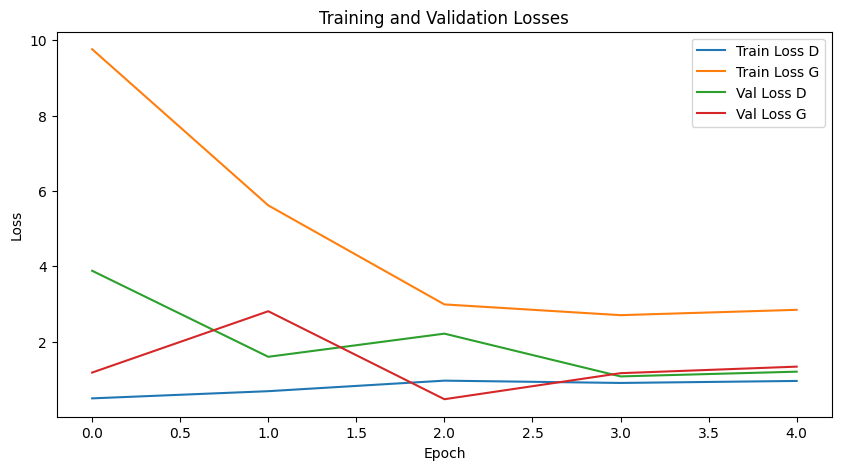

In [11]:
# Plot losses
train_loss_D, train_loss_G = zip(*train_losses)
val_loss_D, val_loss_G = zip(*val_losses)

plt.figure(figsize=(10, 5))
plt.plot(train_loss_D, label="Train Loss D")
plt.plot(train_loss_G, label="Train Loss G")
plt.plot(val_loss_D, label="Val Loss D")
plt.plot(val_loss_G, label="Val Loss G")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Losses")
plt.savefig("gan_outputs/loss_plot.png")
plt.show()


In [12]:
# Generate final images using best model
G.load_state_dict(torch.load("gan_outputs/best_generator.pth"))
G.eval()
with torch.no_grad():
    final_noise = torch.randn(64, z_dim, 1, 1, device=device)
    generated_imgs = G(final_noise)
    save_image(make_grid(generated_imgs, normalize=True), "gan_outputs/final_generated.png")